# Задание из четвёртой лабы

Обучите один из алгоритмов классификации из библиотеки sklearn. Объяснять принцип работы классификатора в этой лабораторной не требуется

1. Выберите один из датасетов первой лабораторной


2. Найдите в данных признак, который будете предсказывать
    
    Если это категория, то у неё должно быть от 2 до 10 значений (например колонка species в датасете миграции птиц содержит 3 категории)
    
    Если признак количественный, то его нужно дискретизировать (например для популярности трека в датасете spotify можно разделить треки на 3 категории: 0-20 - популярные, 21-50 - обычные, 51 - 100 - непопулярные). Полученную категорию записать в датафрейм как отдельную колонку


3. Выделите признаки для предсказания
    
    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной


4. Проверьте нормальность количественных признаков
    
    Используйте статистический тест из лекции. Если распределение является лог-нормальным, логарифмируйте его и проверьте на нормальность
    
    Как минимум 1 из признаков должен быть нормальным


5. Покажите качество предсказания модели с помощью метрик

    Метрика должна учитывать баланс классов в датасете

# Ход работы

Для начала подключим все необходимые библиотеки:

In [1]:
# Импорт базовых библиотек
import numpy as np
import pandas as pd

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# Utils
from scipy import stats
import statistics as st
from sklearn.model_selection import cross_val_score

# Модели (классификация)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Метрики
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Misc
from sklearn.manifold import TSNE

# My utils
from extraUtils import analysisMissingValue
from extraUtils import calculateAge

Для выполнения задания я выбрал данные о просмотре аниме пользователями с сайта [MyAnimeList.net](https://myanimelist.net/).
<p>
Следующим шагом будет загрузка dataset:

In [2]:
df = pd.read_csv('./data/raw/user_data.csv')
df.head()

,name,planning,watched,completed,days_watched,dropped,episodes_watched,mean_score,on_hold,plan_to_watch,rewatched,total_entries,watching,birthday,gender,joined,last_online,location,favorites,genre_count
0,-0,"[{'mal_id': 39764, 'title': 'Detective Conan M...","[{'title': '1', 'mal_id': 29978, 'score': 6, '...",467,181.6,0,11160,7.74,0,7,0,477,3,NaN,NaN,2017-09-19T00:00:00+00:00,2020-09-25 11:03:22+00:00,NaN,"{'anime': [], 'characters': [], 'people': []}","{'Action': 153, 'Adventure': 162, 'Cars': 5, '..."
1,-Droid-,"[{'mal_id': 6408, 'title': '""Bungaku Shoujo"" M...","[{'title': '11eyes', 'mal_id': 6682, 'score': ...",1125,263.3,4,16195,7.80,4,1131,53,2271,7,1930-01-07T00:00:00+00:00,Male,2013-09-07T00:00:00+00:00,2020-09-17 21:07:00+00:00,MA,"{'anime': [{'mal_id': 237, 'title': 'Koukyoush...","{'Action': 447, 'Adventure': 186, 'Cars': 1, '..."
2,-Hentai,"[{'mal_id': 39783, 'title': '5-toubun no Hanay...","[{'title': '3-gatsu no Lion', 'mal_id': 31646,...",887,270.4,60,16189,7.36,9,88,8,1070,26,1991-11-05T00:00:00+00:00,Male,2014-05-19T00:00:00+00:00,2020-09-21 19:11:28+00:00,UAE - Sharjah,"{'anime': [{'mal_id': 31933, 'title': 'JoJo no...","{'Action': 418, 'Adventure': 210, 'Cars': 1, '..."
3,-Jens,"[{'mal_id': 31646, 'title': '3-gatsu no Lion'}...","[{'title': '07-Ghost', 'mal_id': 5525, 'score'...",102,17.8,0,1093,6.81,8,403,0,518,5,NaN,NaN,2020-06-11T00:00:00+00:00,2020-09-24 14:06:00+00:00,Fish tank. I'm stuck.,"{'anime': [{'mal_id': 205, 'title': 'Samurai C...","{'Action': 36, 'Adventure': 9, 'Cars': 0, 'Com..."
4,-Kano,"[{'mal_id': 34777, 'title': '91 Days: Toki no ...","[{'title': '3-gatsu no Lion', 'mal_id': 31646,...",193,65.2,25,3961,6.92,32,70,2,325,5,NaN,NaN,2015-08-12T00:00:00+00:00,2020-09-26 01:29:32+00:00,NaN,"{'anime': [], 'characters': [], 'people': []}","{'Action': 84, 'Adventure': 25, 'Cars': 0, 'Co..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2195 entries, 0 to 2194
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2195 non-null   object 
 1   planning          2195 non-null   object 
 2   watched           2195 non-null   object 
 3   completed         2195 non-null   int64  
 4   days_watched      2195 non-null   float64
 5   dropped           2195 non-null   int64  
 6   episodes_watched  2195 non-null   int64  
 7   mean_score        2195 non-null   float64
 8   on_hold           2195 non-null   int64  
 9   plan_to_watch     2195 non-null   int64  
 10  rewatched         2195 non-null   int64  
 11  total_entries     2195 non-null   int64  
 12  watching          2195 non-null   int64  
 13  birthday          1261 non-null   object 
 14  gender            1751 non-null   object 
 15  joined            2195 non-null   object 
 16  last_online       2195 non-null   object 


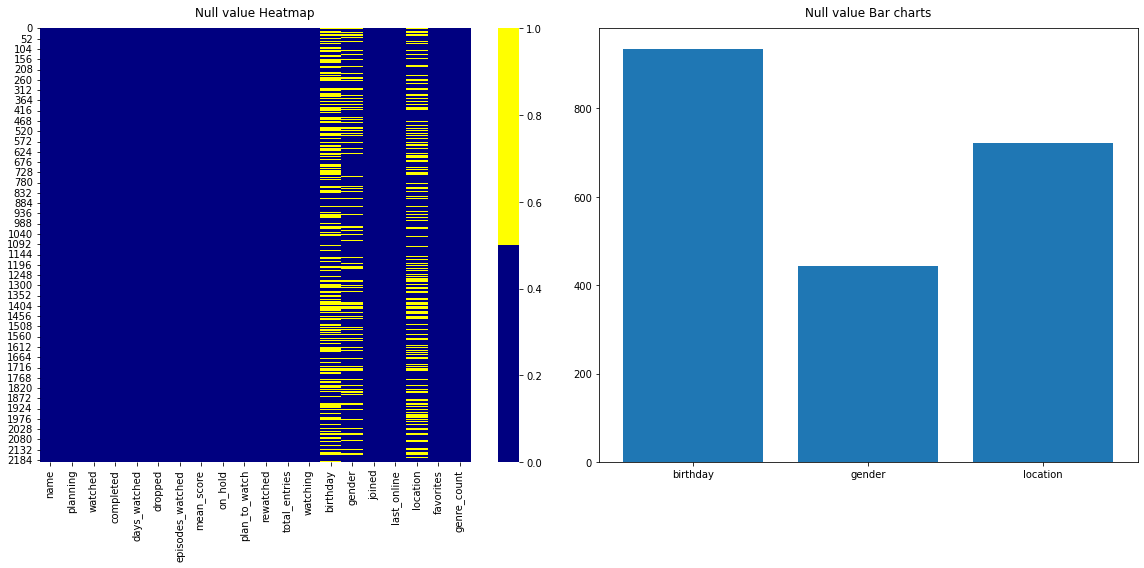

In [3]:
analysisMissingValue.analysis_missing_value(df)

In [4]:
df.describe()

,completed,days_watched,dropped,episodes_watched,mean_score,on_hold,plan_to_watch,rewatched,total_entries,watching
count,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000
mean,433.814123,122.496674,28.907517,7719.424146,7.066588,19.630979,192.500683,20.524829,694.082005,19.226879
std,701.161822,131.530904,208.860362,9390.248439,1.515720,49.139325,445.081841,90.231621,995.627147,57.267595
min,3.000000,0.400000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,157.000000,51.500000,1.000000,3153.500000,6.615000,1.500000,34.000000,0.000000,280.500000,4.000000
50%,273.000000,90.700000,8.000000,5518.000000,7.260000,7.000000,94.000000,1.000000,472.000000,8.000000
75%,490.500000,148.550000,24.000000,9233.000000,7.890000,19.000000,212.000000,13.000000,796.500000,17.000000
max,14025.000000,1928.400000,9012.000000,151474.000000,10.000000,1400.000000,12517.000000,2515.000000,17118.000000,1747.000000


In [5]:
new_df = df.copy()
new_df['gender'] = new_df['gender'].fillna('Other')
new_df['location'] = new_df['location'].fillna('Other')
new_df = new_df.drop(['name',
                      'planning',
                      'watched',
                      'last_online',
                      'favorites',
                      'genre_count',
                      'location',
                      'joined'], axis=1)
new_df['birthday'] = new_df['birthday'].str[:-15]
new_df['birthday'] = pd.to_datetime(new_df['birthday'], format='%Y-%m-%d')
new_df['birthday'] = new_df['birthday'].fillna(new_df['birthday'].mean())
new_df['birthday'] = new_df['birthday'].dt.strftime('%Y-%m-%d')
new_df['birthday'] = pd.to_datetime(new_df['birthday'], format='%Y-%m-%d')

new_df.loc[:, 'age'] = new_df['birthday'].apply(calculateAge.calculateAge)
new_df = new_df.drop(['birthday'], axis=1)

new_df.head()

,completed,days_watched,dropped,episodes_watched,mean_score,on_hold,plan_to_watch,rewatched,total_entries,watching,gender,age
0,467,181.6,0,11160,7.74,0,7,0,477,3,Other,23
1,1125,263.3,4,16195,7.80,4,1131,53,2271,7,Male,91
2,887,270.4,60,16189,7.36,9,88,8,1070,26,Male,29
3,102,17.8,0,1093,6.81,8,403,0,518,5,Other,23
4,193,65.2,25,3961,6.92,32,70,2,325,5,Other,23


In [6]:
new_df.to_csv('./data/processed/user_data_new.csv')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2195 entries, 0 to 2194
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   completed         2195 non-null   int64  
 1   days_watched      2195 non-null   float64
 2   dropped           2195 non-null   int64  
 3   episodes_watched  2195 non-null   int64  
 4   mean_score        2195 non-null   float64
 5   on_hold           2195 non-null   int64  
 6   plan_to_watch     2195 non-null   int64  
 7   rewatched         2195 non-null   int64  
 8   total_entries     2195 non-null   int64  
 9   watching          2195 non-null   int64  
 10  gender            2195 non-null   object 
 11  age               2195 non-null   int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 205.9+ KB


За множество меток я хочу взять пол юзера.
То есть я хочу, чтобы алгоритм по объекту, который состоит из признаков
 * completed
 * days_watched
 * dropped
 * episodes_watched
 * mean_score
 * on_hold
 * plan_to_watch
 * rewatched
 * total_entries
 * watching
 * age

смог определить пол юзера.

In [7]:
X = new_df.drop(['gender'], axis=1)
y = new_df[['gender']]
y = np.squeeze(y)

print(f'Type X: {type(X)}, X shape: {X.shape}')
print(f'Type y: {type(y)}, y shape: {y.shape}')

Type X: <class 'pandas.core.frame.DataFrame'>, X shape: (2195, 11)
Type y: <class 'pandas.core.series.Series'>, y shape: (2195,)


(array(['Female', 'Male', 'Non-Binary', 'Other'], dtype=object), array([ 456, 1270,   25,  444]))


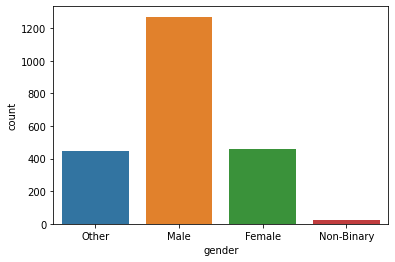

In [8]:
# Взглянем на распределение метки в данных
print(np.unique(new_df.gender, return_counts=True))
sns.countplot(x='gender', data=new_df);

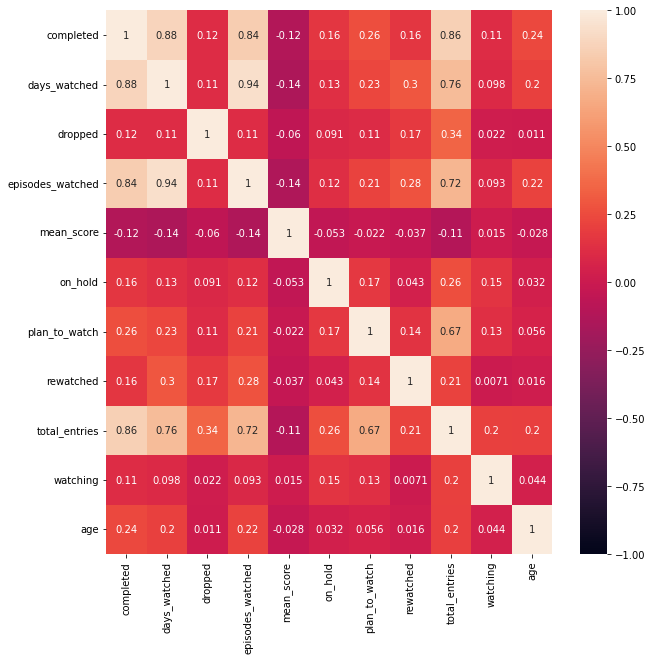

In [9]:
# Проверим признаки на их попарную корреляцию
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(new_df.corr(), vmin=-1, vmax=1, annot=True, ax=ax);

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


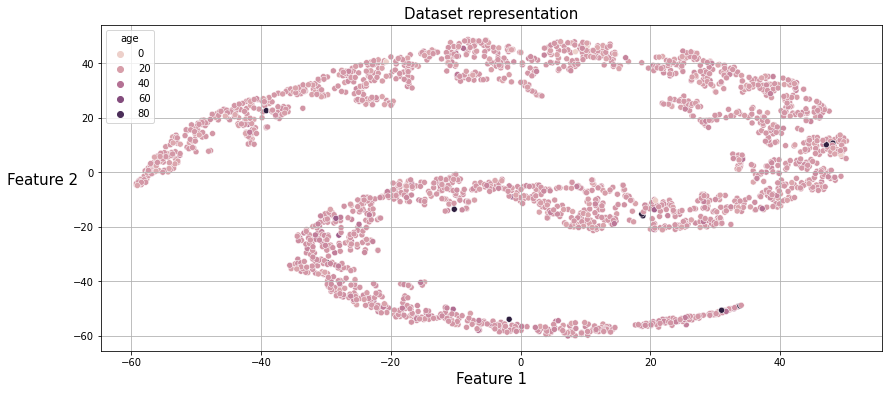

In [10]:
# Попробуем описать имеющиеся данные в пространстве меньшей размерности
X_embedded = TSNE(n_components=2, random_state=993).fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

ax.set_title('Dataset representation', fontsize=15)
ax.set_xlabel('Feature 1', fontsize=15)
ax.set_ylabel('Feature 2', rotation=0, labelpad=30, fontsize=15)
ax.grid()

sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=new_df.age,
    ax=ax
);

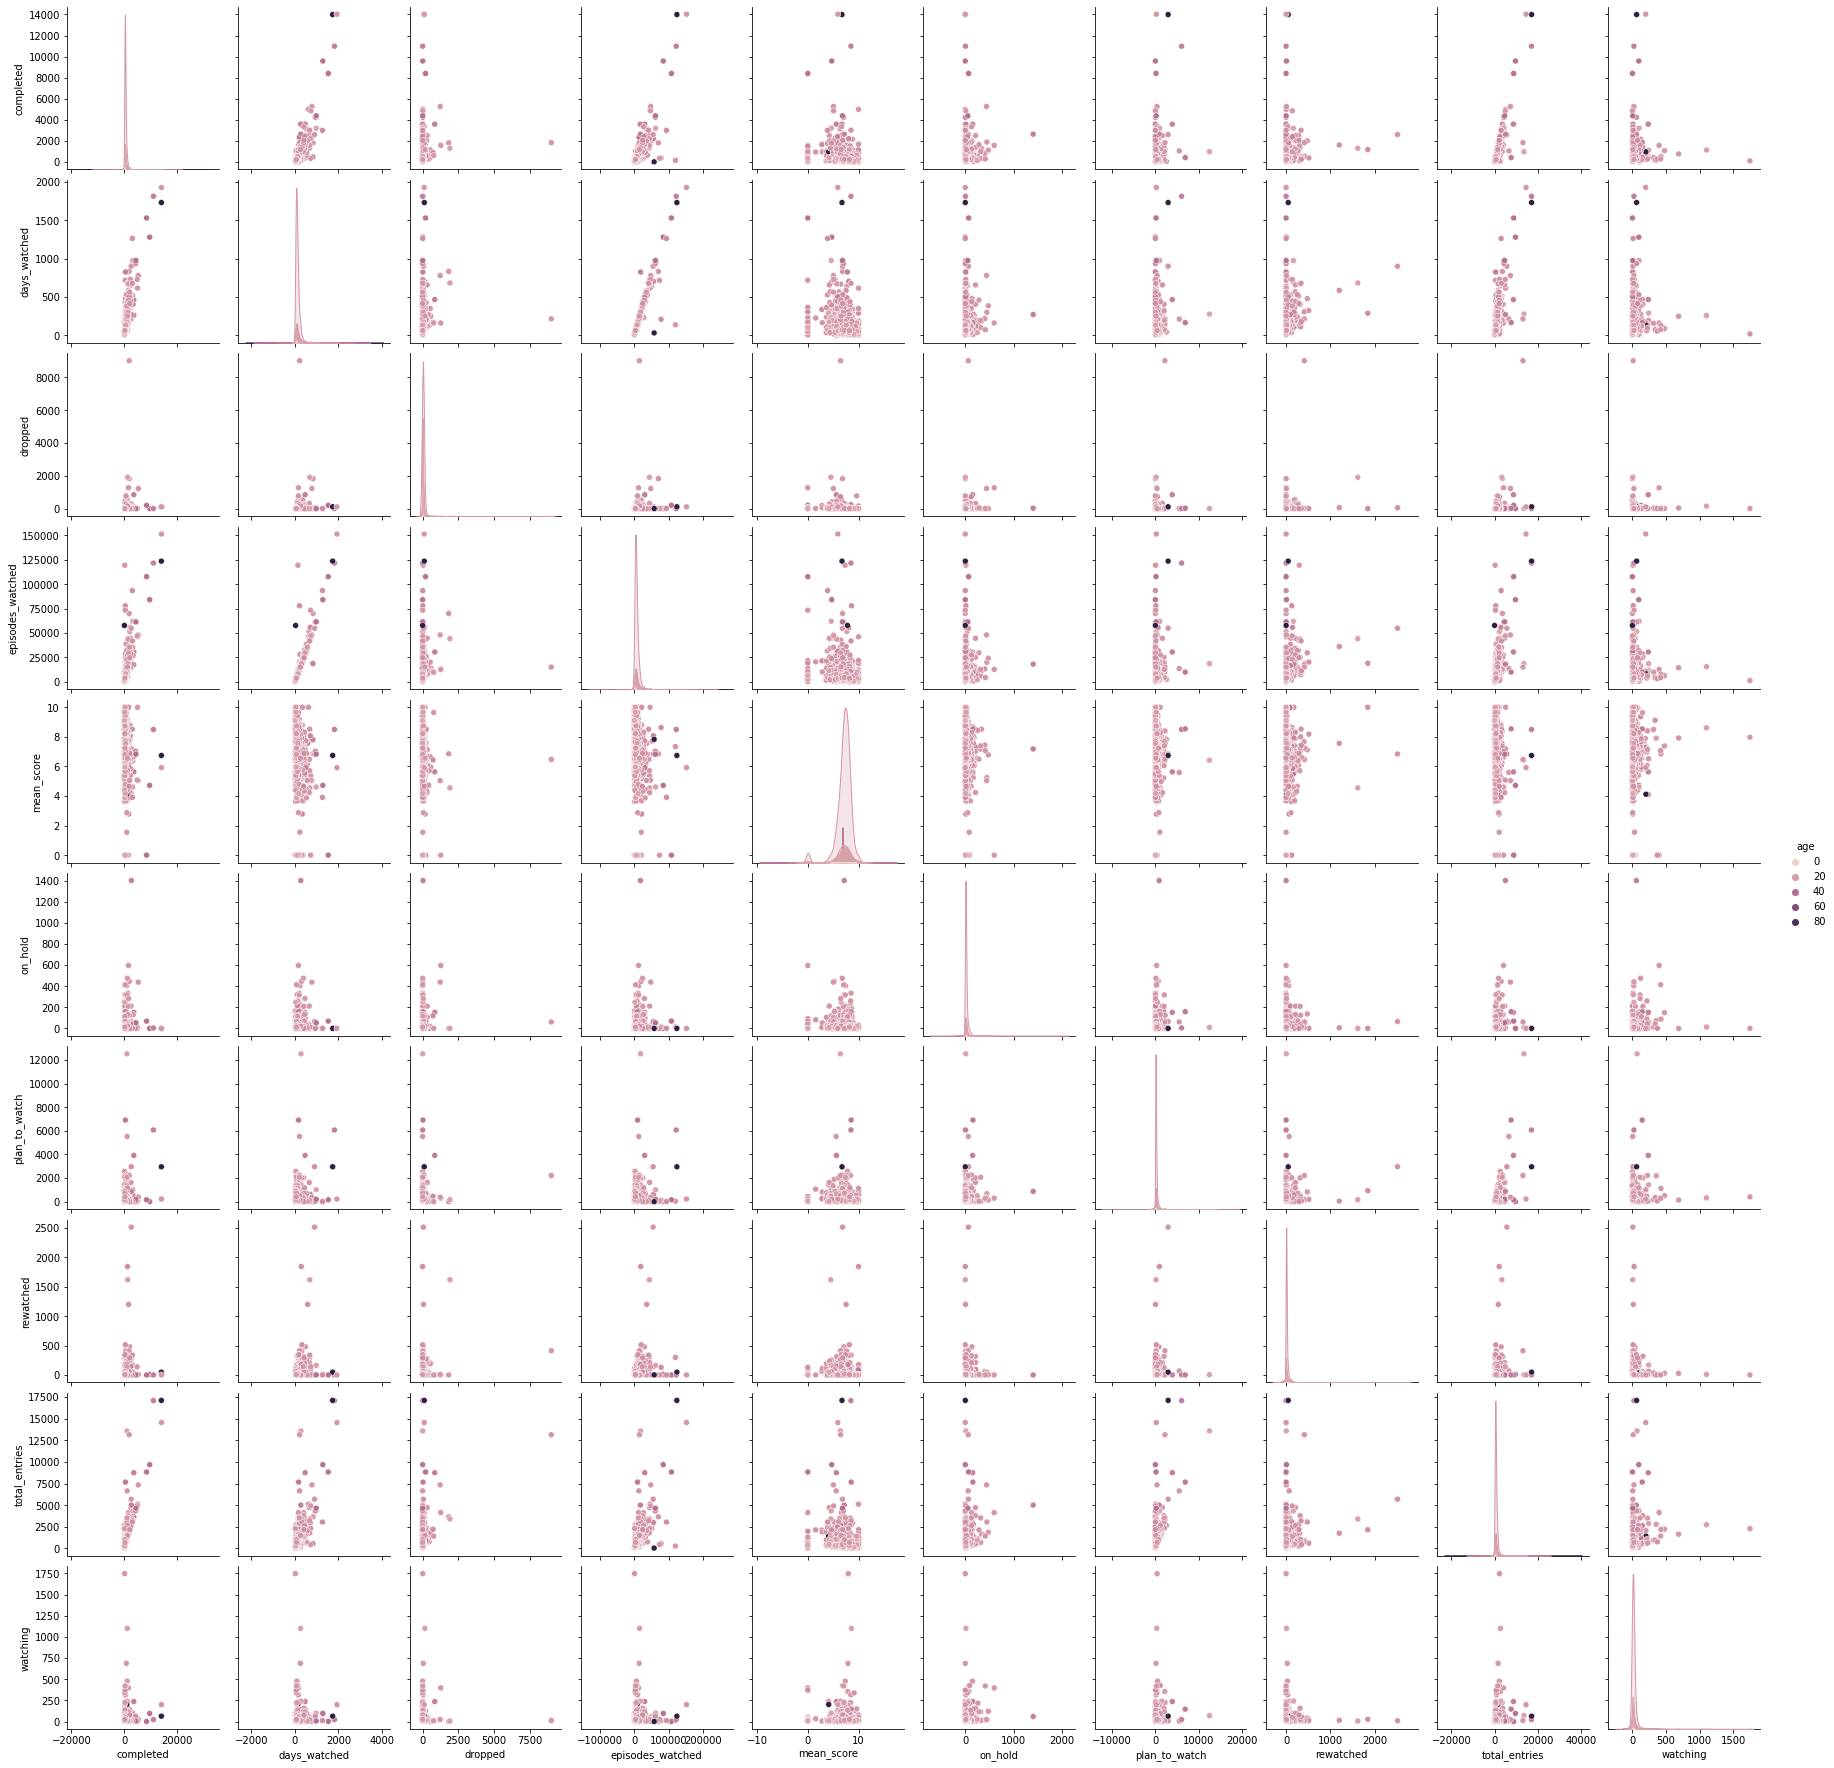

In [12]:
# Рассмотрим попарные представления данных и гистограммы для одиночных признаков
sns.pairplot(new_df, hue='age');

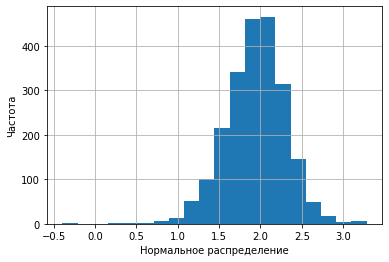

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2195 entries, 0 to 2194
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   completed         2195 non-null   int64  
 1   days_watched      2195 non-null   float64
 2   dropped           2195 non-null   int64  
 3   episodes_watched  2195 non-null   int64  
 4   mean_score        2195 non-null   float64
 5   on_hold           2195 non-null   int64  
 6   plan_to_watch     2195 non-null   int64  
 7   rewatched         2195 non-null   int64  
 8   total_entries     2195 non-null   int64  
 9   watching          2195 non-null   int64  
 10  gender            2195 non-null   object 
 11  age               2195 non-null   int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 205.9+ KB


In [11]:
pd.Series(np.log10(new_df['days_watched'])).hist(bins=20)
plt.xlabel('Нормальное распределение')
plt.ylabel('Частота')
plt.show()
new_df.info()

In [13]:
# new_df.drop(new_df.index[:500],axis = 0, inplace = True)
# new_df.drop(new_df.index[:-500],axis = 0, inplace = True)
new_df = new_df.loc[(new_df['mean_score'] > 6) & (new_df['mean_score'] < 8)]

for col in new_df.columns:
    if col == 'gender':
        continue
    print('{} - {}'.format(col, stats.normaltest(new_df[col])))

completed - NormaltestResult(statistic=2634.0914309722007, pvalue=0.0)
days_watched - NormaltestResult(statistic=1448.1168651856792, pvalue=0.0)
dropped - NormaltestResult(statistic=4087.114174181469, pvalue=0.0)
episodes_watched - NormaltestResult(statistic=1802.8224480371055, pvalue=0.0)
mean_score - NormaltestResult(statistic=195.54332304207384, pvalue=3.4538773782084125e-43)
on_hold - NormaltestResult(statistic=2918.660093821789, pvalue=0.0)
plan_to_watch - NormaltestResult(statistic=3079.921309922039, pvalue=0.0)
rewatched - NormaltestResult(statistic=3262.4913553921797, pvalue=0.0)
total_entries - NormaltestResult(statistic=2351.709426907063, pvalue=0.0)
watching - NormaltestResult(statistic=3248.809020627379, pvalue=0.0)
age - NormaltestResult(statistic=1857.793220682355, pvalue=0.0)


In [14]:
for col in new_df.columns:
    if col == 'gender':
        continue
    result = stats.normaltest(np.log10(new_df[col]))
    print('{} - {}'.format(col, result))

completed - NormaltestResult(statistic=8.853113847986714, pvalue=0.01195558286921688)
days_watched - NormaltestResult(statistic=4.98916495945573, pvalue=0.08253090252410286)
dropped - NormaltestResult(statistic=nan, pvalue=nan)
episodes_watched - NormaltestResult(statistic=8.220939972957067, pvalue=0.016400064905973028)
mean_score - NormaltestResult(statistic=140.4769869791416, pvalue=3.131914231717869e-31)
on_hold - NormaltestResult(statistic=nan, pvalue=nan)
plan_to_watch - NormaltestResult(statistic=nan, pvalue=nan)
rewatched - NormaltestResult(statistic=nan, pvalue=nan)
total_entries - NormaltestResult(statistic=26.385474701529574, pvalue=1.8640903892963788e-06)
watching - NormaltestResult(statistic=nan, pvalue=nan)
age - NormaltestResult(statistic=nan, pvalue=nan)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# Инициализируем алгоритмы с параметрами по-умолчанию
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

# Посчитаем метрику качества используя кросс-валидацию
knn_acc_score = cross_val_score(knn_clf, X, y, cv=7).mean()
svm_acc_score = cross_val_score(svm_clf, X, y, cv=7).mean()
forest_acc_score = cross_val_score(forest_clf, X, y, cv=7).mean()

# Выведем алгоритмы по убыванию качества их работы
leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('SVC', svm_acc_score),
    ('Forest', forest_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X do

Leaderboard:
1. Forest: 0.5890644123179073
2. SVC: 0.578590179280031
3. KNN: 0.5011381244058641
